## **Overview**
**we will explore how to develop a suite of different types of LSTM models for time series forecasting.**

* ### **Univariate LSTM Models**

1. Data Preparation
2. Vanilla LSTM
3. Stacked LSTM
4. Bidirectional LSTM
5. CNN LSTM
6. ConvLSTM


* ### **Multivariate LSTM Models**

* ### **Multi-Step LSTM Models**

* ### **Multivariate Multi-Step LSTM Models**



In [8]:
import matplotlib
import warnings
# 忽略警告
warnings.filterwarnings("ignore", category=matplotlib.MatplotlibDeprecationWarning)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score as r2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
# from scikeras.wrappers import KerasRegressor # 回归神经网络
from numpy import array
from keras.models import Sequential
from keras.layers import TimeDistributed
from keras.layers import Dense
from keras.layers import MaxPooling1D, Conv1D,Flatten
# univariate bidirectional lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.python.keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
import keras.backend as K
import os
import glob
import tensorflow as tf
from tensorflow.python.keras.layers import Activation
from keras import optimizers
from pygame import mixer
import time
from keras.layers import Bidirectional
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

In [9]:
def read_someone_day_file(day):
    IMF = []
    xlsx_file = '../../Data/CEEMDAN/58606_2/'+day+'/'
    xlsx_path = glob.glob(os.path.join(xlsx_file,'*.xlsx'))

    data_col_len = pd.read_excel('../../Data/CEEMDAN/58606_2/'+day+'/CEEMDAN_58606 Station_g.xlsx',header=None)

    for imf_len in range(len(data_col_len.columns)):
        for file in xlsx_path:
             print(file)
             # print(os.path.basename(file))
             imfs = pd.read_excel(file,header=None)
             imfn = imfs.iloc[:,imf_len]
             imfn.to_numpy()
             IMF.append(imfn )
        print(imf_len,"-------------------")
    return IMF

In [10]:
def Result_Ana(Model, feature_num,testX,testY,scaler):
    print('Result_Ana_Function:',testX.shape)
    y_pred = Model.predict(testX)
    y_pred = np.array(y_pred).reshape(-1, 1)
    # 将一个数组prediction在最后一个轴上（即axis=-1）进行复制，重复8次，并将结果存储在prediction_copies_array数组中
    prediction_copies_array = np.repeat(y_pred, feature_num,axis=-1)
    prediction_copies_array
    print('-----------prediction copy Shape：',prediction_copies_array.shape,'------------------')
    # Multi Var prediction
    pred = scaler.inverse_transform(np.reshape(prediction_copies_array, (len(y_pred), feature_num)))[:,feature_num-1] #进行逆变换但是，只需要最后一列
    # Single prediction
    # pred = scaler.inverse_transform(y_pred) #进行逆变换但是，只需要最后一列

    # print(pred)
    print('testY of shape :',testY.shape)
    y_true = np.array(testY).reshape(-1, 1)
    original_copies_array = np.repeat(testY, feature_num, axis=-1)
    print('IMF_True:',scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num))))
    y_true = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), feature_num)))[:, feature_num-1]

    print('feature_num-1_ETO_true:',y_true)

    # Single true value
    # y_true = scaler.inverse_transform(np.array(testY).reshape(-1,1))

    # y_true
    # pred

    print(pred)
    plt.plot(y_true, color='red', label='Real Value')
    plt.plot(pred, color='blue', label='Pred Value')
    plt.title('Prediction ETO (mm)')
    plt.xlabel('Time (day)')
    plt.ylabel('ETO (mm)')
    plt.legend()
    plt.show()


    print('MSE:',mse(y_true,pred))
    print('MAE:',mae(y_true,pred))
    print('R²:',r2(y_true,pred))
    print('RMSE:',np.sqrt(mse(y_true,pred)))
    print('pred_finally:',pred)

    return y_true,pred

In [11]:
def ceemdan_lstm(day):
    mixer.init()
    mixer.music.load('../../Resources/ExecuteTipAudio.mp3')

    reshape1 = 0
    IMF = read_someone_day_file(day)

    imf_choose = 0
    finally_rsult = []
    finally_y_true = []

    for imf_run in range(int(len(IMF) / 7)):
        ALL_Factor_IMF = IMF[imf_choose:imf_choose+7][:]
        imf_choose = imf_choose + 7

        print('--------------------------',imf_run,'--------------------------')
        ALL_Factor_IMF = np.array(ALL_Factor_IMF)
        IMF_Input = np.transpose(ALL_Factor_IMF)

        df_IMF = pd.DataFrame(IMF_Input)
        df_IMF.columns = ['one','two','three','four','five','six', 'seven']

        print(df_IMF)

        scaler = MinMaxScaler(feature_range=(0, 1))
        df = scaler.fit_transform(df_IMF)

        sacler_data_len = len(df_IMF.columns)

        #数据集划分
        test_split = round(len(df) * 0.20)
        print(test_split)
        def splitData(var, per_test):
            num_test = int(len(var) * per_test)
            train_size = int(len(var) - num_test)
            train_data = var[0:train_size]
            test_data = var[train_size:train_size + num_test]
            return train_data, test_data


        df_training, df_testing = splitData(df, 0.2)
        print('df_training.shape:',df_training.shape)
        print('df_testing.shape:',df_testing.shape)

        def createXY(data,n_past,n_steps_out):
            dataX,dataY = list(),list()

            for i in range(len(data)):
                ## such as: len(data) = 19624
                end_ix = i + n_past ## 0+3=3,1+3=4,...,19618+3=19621
                out_end_ix = end_ix + n_steps_out ## 3+3=6,4+3=7,...,19621+3=19624
                # print('out_end_ix:',out_end_ix)
                '''
                加入此处判断，使得最终的dataX和dataY中每行的数组长度一致，进而可以转换为array(数组),如若不加以限制，
                则导致最后几次循环由于i是在len(data)范围内的，
                但是由于out_end_ix=end_ix + n_steps_out,最终会超出data的数据范围，而导致其无法获取到数据,
                加入dataY之后，最后几行的数据长度是和前面的数据长度不一致，最终导致无法进行array转换
                '''
                if out_end_ix > len(data): ## 6 < len(data),7<len(data),...,19623+3=19626>len(data)=19624
                    # print("------------out_end_ix of end",out_end_ix,'---------------')
                    break

                dataX.append(data[i:end_ix,0:data.shape[1]]) ## 0:3,0:7;1:4,0:7
                dataY.append(data[end_ix:out_end_ix,data.shape[1]-1]) ##3:6,6;4:7,6
            return np.array(dataX), np.array(dataY)

        n_past=1
        n_steps_out=1

        trainX, trainY = createXY(df_training, n_past, n_steps_out)
        testX, testY = createXY(df_testing, n_past, n_steps_out)

        reshape1 = testY.shape[0]

        print('trainX.Shape:----', trainX.shape)
        print('trainY.shape:----', trainY.shape)
        print('testX.shape:----', testX.shape)
        print('testY.shape:----', testY.shape)

        trainY = trainY.reshape(-1)
        testY = testY.reshape(-1)
        print('trainY Shape 2 ---', trainY.shape)
        print('testY Shape 2 ---', testY.shape)
        trainX = np.expand_dims(trainX,axis=1)
        testX = np.expand_dims(testX,axis=1)
        print('expand_dims_trainX of shape',trainX.shape)
        print('expand_dims_testX of shape',testX.shape)

        print('----------------------------',imf_run,'------------------------------')

        def CNN_BiLSTM(optimizer='adam', batch_size=32, epochs=40):

            model = Sequential()
            # Modify kernel_size=1 can execute?
            model.add(TimeDistributed(Conv1D(filters=256, kernel_size=1, activation='relu', input_shape=(None, 1, 7),padding='same')))
            model.add(TimeDistributed(Conv1D(filters=256, kernel_size=1, activation='relu')))
            model.add(TimeDistributed(Dropout(0.1)))
            model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
            model.add(TimeDistributed(Flatten()))
            model.add(Dense(100, activation='relu'))
            model.add(Bidirectional(LSTM(150, activation='relu')))
            model.add(Dropout(0.1))
            model.add(Dense(1))
            # model.add(Activation('linear'))
            model.compile(optimizer=optimizer, loss='mse', metrics='accuracy')
            return model

        CNN_BiLSTM_Model = KerasRegressor(CNN_BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))
        # N_LSTM_Model = KerasRegressor(N_LSTM, epochs=40, verbose=1)

        from sklearn.model_selection import GridSearchCV

        # 定义超参数搜索范围
        param_grid = {
            'optimizer': ['Adam'],
            'batch_size': [32, 64],
            'epochs': [20, 30]
            # 'batch_size': [64],
            # 'epochs': [40]
        }

        # 执行网格搜索
        grid = GridSearchCV(estimator=CNN_BiLSTM_Model, param_grid=param_grid, cv=2)
        grid_result = grid.fit(trainX, trainY)

        best_params = grid_result.best_params_

        best_params
        print('prediction' , 'one' ,'day best_params:', best_params)

        best_model = grid_result.best_estimator_

        y_trues,prediction_result = Result_Ana(best_model, sacler_data_len,testX,testY,scaler)

        print('prediction_result:',prediction_result)
        finally_rsult.append(prediction_result)
        print('lstm_y_turs:',y_trues)
        finally_y_true.append(y_trues)

        mixer.music.play()
        time.sleep(1)
        mixer.music.stop()
    return reshape1,finally_y_true,finally_rsult,day

In [12]:
def plot_save_true_prediction(reshape1,finally_y_true,finally_rsult,day):
    # WL(Water Level(m)) For IMF1-IMF13-R True Value
    finally_y_true
    finally_ytrue_r = np.array(finally_y_true)
    finally_ytrue_r
    reshape2 = len(finally_ytrue_r)
    reshape2
    finally_column_names = []

    for i in range(1, reshape2 + 1):
        if i < (reshape2):
            finally_column_names.append("IMF" + str(i))
        else:
            finally_column_names.append("Residual")
    finally_column_names
    ALL_Factor_ReIMFS_Yture_Result = np.transpose(finally_ytrue_r)
    reshape1
    ALL_Factor_ReIMFS_Yture_Result = ALL_Factor_ReIMFS_Yture_Result.reshape(reshape1, reshape2)
    all_factor_ceemdan_true = pd.DataFrame(ALL_Factor_ReIMFS_Yture_Result, columns=finally_column_names)
    all_factor_ceemdan_true
    sums = all_factor_ceemdan_true.iloc[:, :].sum(axis=1)

    # 将求和结果添加到DataFrame中作为新的一列
    all_factor_ceemdan_true["True"] = sums
    # 保存为CSV文件
    true_file_path = "Result/CEEMDAN/"+day+"_day_CEEMDAN_IMF" + str(reshape2 - 1) + "-CNNBiLSTM_true.csv"

    all_factor_ceemdan_true.to_csv(true_file_path,
                                   index=False)
    # WL(Water Level(m)) IMF1-IMF13-R Prediction Value
    finally_rsult
    finally_r = np.array(finally_rsult)
    finally_r
    ALL_Factor_ReIMFS_Result = np.transpose(finally_r)
    ALL_Factor_ReIMFS_Result = ALL_Factor_ReIMFS_Result.reshape(reshape1, reshape2)
    finally_column_names
    all_factor_ceemdan_prediction = pd.DataFrame(ALL_Factor_ReIMFS_Result, columns=finally_column_names)
    all_factor_ceemdan_prediction
    sums = all_factor_ceemdan_prediction.iloc[:, :].sum(axis=1)

    # 将求和结果添加到DataFrame中作为新的一列
    all_factor_ceemdan_prediction["Pred"] = sums
    prediction_file_path = "Result/CEEMDAN/"+day+"_day_CEEMDAN_IMF" + str(reshape2 - 1) + "-CNNBiLSTM_prediction.csv"
    # 保存为CSV文件
    all_factor_ceemdan_prediction.to_csv(prediction_file_path, index=False)
    ### 验证最终结果
    df = pd.read_csv(prediction_file_path)
    df = df[['Pred']]
    df

    origin = pd.read_csv(true_file_path)
    origin = origin[['True']]
    # y_true = origin.iloc[:,len(origin.columns)-1]
    y_true = origin
    y_true
    pred = df
    y_true
    pred
    plt.plot(y_true, color='red', label='Real Value')
    plt.plot(pred, color='blue', label='Pred Value')
    plt.title('Prediction ET0 ')
    plt.xlabel('Time')
    plt.ylabel('Detail Value')
    plt.legend()
    # plt.savefig('../Images/SW_IN_F_Train_'+'n_past='+'{}'.format((trainX[1].shape)[0])+'_epochs={}'.format((grid_search.best_params_)['epochs'])+'.png',dpi=600)
    plt.show()
    # y_true_data = pd.DataFrame(y)
    # y_true_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_True' + '.csv',
    #               index=False)
    # pred_data = pd.DataFrame(pred)
    # pred_data.to_csv('../ResultAnaAndProcess/Result/All Features/RF/37390_300/' + 'RF_{}'.format(site_name) + '_Pre' + '.csv',
    #              index=False)
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.metrics import r2_score as r2

    print('MSE:', mse(y_true, pred))
    print('MAE:', mae(y_true, pred))
    print('R²:', r2(y_true, pred))
    print('RMSE:', np.sqrt(mse(y_true, pred)))
    print('pred_finally:', pred)

------------------ OneDay --------------------
This is  OneDay -th for prediction et0
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_b.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_c.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_d.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_e.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_f.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_g.xlsx
0 -------------------
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_a.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_b.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_c.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_d.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_e.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_f.xlsx
../../Data/CEEMDAN/58606_2/OneDay\CEEMDAN_58606 Station_g.xlsx
1 --------

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_17876\2926629309.py:108: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_BiLSTM_Model = KerasRegressor(CNN_BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 4s 5ms/step - loss: 0.0160 - accuracy: 0.0000e+00 - val_loss: 0.0132 - val_accuracy: 2.0387e-04
Epoch 2/20
307/307 [==============================] - 1s 4ms/step - loss: 0.0113 - accuracy: 0.0000e+00 - val_loss: 0.0123 - val_accuracy: 2.0387e-04
Epoch 3/20
307/307 [==============================] - 1s 4ms/step - loss: 0.0108 - accuracy: 0.0000e+00 - val_loss: 0.0118 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 1s 4ms/step - loss: 0.0107 - accuracy: 0.0000e+00 - val_loss: 0.0117 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 1s 4ms/step - loss: 0.0106 - accuracy: 0.0000e+00 - val_loss: 0.0115 - val_accuracy: 2.0387e-04
Epoch 6/20
307/307 [==============================] - 1s 4ms/step - loss: 0.0106 - accuracy: 0.0000e+00 - val_loss: 0.0115 - val_accuracy: 2.0387e-04
Epoch 7/20
307/307 [==============================] - 1s 4ms/step - loss: 0.0105 - accuracy: 0.0000e+00 - val_l

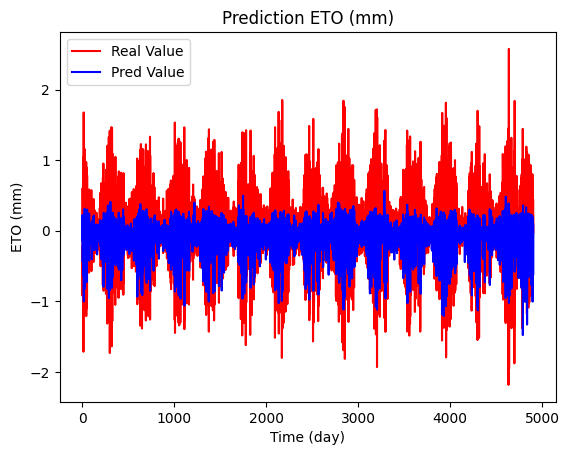

MSE: 0.25608921383178945
MAE: 0.3620881905660361
R²: 0.07184895954830084
RMSE: 0.5060525801058517
pred_finally: [-0.42942306 -0.03489539  0.22194347 ...  0.04912715 -0.6285166
  0.09003974]
prediction_result: [-0.42942306 -0.03489539  0.22194347 ...  0.04912715 -0.6285166
  0.09003974]
lstm_y_turs: [-0.22846669 -0.9194061   0.47041622 ...  0.22694627 -0.03973494
  0.43138383]
-------------------------- 1 --------------------------
            one       two     three      four      five            six  \
0     -0.717649 -0.700243 -1.302272  1.167898  2.246833    -266.541681   
1     -0.067041  0.133359 -1.809280  1.549877  0.945760    -702.111248   
2      0.406846  0.474059 -0.593264  1.616759  0.143621    -308.938576   
3      0.233040  0.235515  1.043773  1.200236 -0.919376     127.959321   
4     -0.127228 -0.141003  1.191214  0.368845 -0.945895      63.058347   
...         ...       ...       ...       ...       ...            ...   
24525  0.130000  0.020085 -0.993216  0.027438 -

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_17876\2926629309.py:108: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_BiLSTM_Model = KerasRegressor(CNN_BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 4s 5ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 0.0020 - val_accuracy: 2.0387e-04
Epoch 2/20
307/307 [==============================] - 1s 4ms/step - loss: 0.0022 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 2.0387e-04
Epoch 3/20
307/307 [==============================] - 1s 4ms/step - loss: 0.0021 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 2.0387e-04
Epoch 4/20
307/307 [==============================] - 1s 4ms/step - loss: 0.0020 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 2.0387e-04
Epoch 5/20
307/307 [==============================] - 1s 4ms/step - loss: 0.0020 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 2.0387e-04
Epoch 6/20
307/307 [==============================] - 1s 4ms/step - loss: 0.0019 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 2.0387e-04
Epoch 7/20
307/307 [==============================] - 1s 4ms/step - loss: 0.0019 - accuracy: 0.0000e+00 - val_l

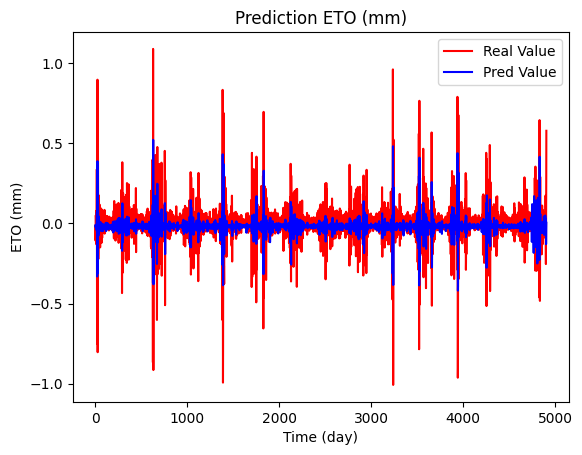

MSE: 0.010212342446426007
MAE: 0.059989453077904493
R²: 0.2556517975226058
RMSE: 0.10105613512511749
pred_finally: [-0.01266852 -0.02320974 -0.02501972 ... -0.10228146 -0.04356842
  0.00401888]
prediction_result: [-0.01266852 -0.02320974 -0.02501972 ... -0.10228146 -0.04356842
  0.00401888]
lstm_y_turs: [-0.01562149 -0.10756524 -0.02491552 ...  0.08294097  0.29797894
  0.57746203]
-------------------------- 2 --------------------------
            one       two     three      four      five            six  \
0     -0.341676  0.979711 -1.181582  0.350818  2.414864     -59.147632   
1     -0.104460  1.669276 -1.545486  0.553184  1.936741    1205.856175   
2     -0.321276  1.773475 -0.876626  0.632451 -0.862360     165.532785   
3     -0.536460  0.647876  0.331070  0.421779 -3.845997   -1139.985967   
4     -0.454172 -0.598511  1.085067  0.130059 -4.377561      37.511552   
...         ...       ...       ...       ...       ...            ...   
24525 -0.816230 -0.477108 -1.100900 -0.070

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_17876\2926629309.py:108: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_BiLSTM_Model = KerasRegressor(CNN_BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 4s 7ms/step - loss: 0.0106 - accuracy: 2.0385e-04 - val_loss: 0.0038 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 2s 6ms/step - loss: 0.0038 - accuracy: 2.0385e-04 - val_loss: 0.0037 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 2s 6ms/step - loss: 0.0039 - accuracy: 2.0385e-04 - val_loss: 0.0034 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 2s 6ms/step - loss: 0.0038 - accuracy: 2.0385e-04 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 2s 6ms/step - loss: 0.0035 - accuracy: 2.0385e-04 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 2s 6ms/step - loss: 0.0035 - accuracy: 2.0385e-04 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 2s 6ms/step - loss: 0.0036 - accuracy: 2.0385e-04 - val_l

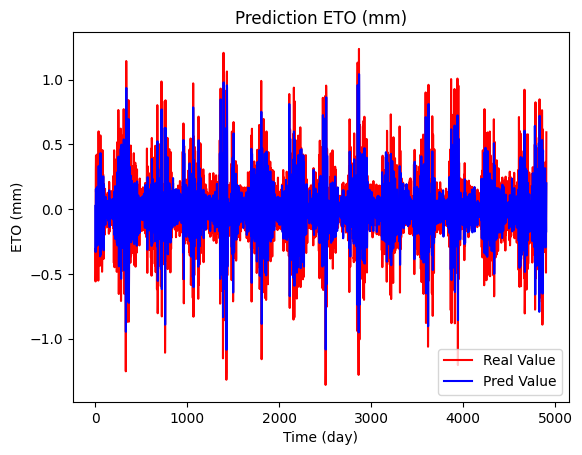

MSE: 0.03665957653888456
MAE: 0.14253691423514273
R²: 0.5235461470316247
RMSE: 0.19146690716383488
pred_finally: [ 0.02556374 -0.19694763 -0.3301664  ... -0.02656668  0.08040769
  0.19970177]
prediction_result: [ 0.02556374 -0.19694763 -0.3301664  ... -0.02656668  0.08040769
  0.19970177]
lstm_y_turs: [-0.30608954 -0.55767852 -0.47324348 ...  0.16486849  0.46517182
  0.59421051]
-------------------------- 3 --------------------------
            one       two     three      four      five            six  \
0     -0.661736  1.203007 -1.923127  0.080471 -1.565418    -384.149923   
1     -0.802548  1.606931 -2.090151  0.157180 -2.150125     245.882729   
2     -0.699025  1.505821 -1.652161  0.134042 -2.440051     507.008948   
3     -0.725270  0.975604 -0.892493  0.064260 -2.023263     -16.046745   
4     -0.697584  0.506975 -0.079269 -0.015150 -0.811144    -337.765596   
...         ...       ...       ...       ...       ...            ...   
24525 -0.376335 -1.304232 -0.481655 -0.09030

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_17876\2926629309.py:108: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_BiLSTM_Model = KerasRegressor(CNN_BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 4s 7ms/step - loss: 0.0079 - accuracy: 2.0385e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 2s 6ms/step - loss: 0.0022 - accuracy: 2.0385e-04 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 2s 7ms/step - loss: 0.0020 - accuracy: 2.0385e-04 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 2s 7ms/step - loss: 0.0019 - accuracy: 2.0385e-04 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 2s 7ms/step - loss: 0.0019 - accuracy: 2.0385e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 2s 7ms/step - loss: 0.0019 - accuracy: 2.0385e-04 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 2s 7ms/step - loss: 0.0018 - accuracy: 2.0385e-04 - val_l

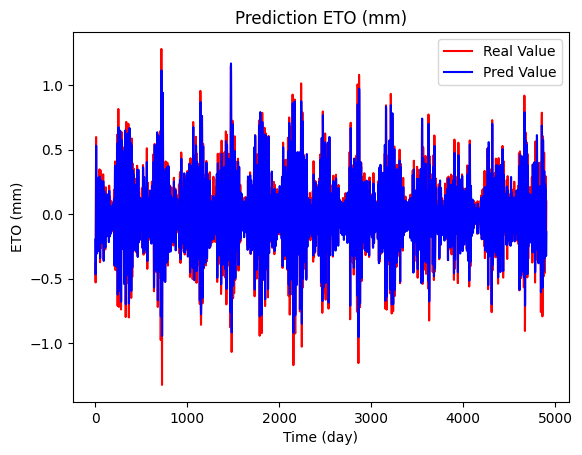

MSE: 0.018856649204886375
MAE: 0.10518470867324171
R²: 0.7784086647673599
RMSE: 0.13731951501839196
pred_finally: [-0.19804081 -0.36025602 -0.46704233 ... -0.27387053 -0.20749576
 -0.14046292]
prediction_result: [-0.19804081 -0.36025602 -0.46704233 ... -0.27387053 -0.20749576
 -0.14046292]
lstm_y_turs: [-0.38186312 -0.51136228 -0.53018441 ... -0.07308708  0.03796344
  0.09813321]
-------------------------- 4 --------------------------
            one       two     three      four      five           six  \
0     -0.389531  0.586490 -0.654795 -0.110076  2.704542    172.547296   
1     -0.353339  0.560630 -0.630126 -0.125011  2.992187    292.905825   
2     -0.351755  0.394267 -0.444077 -0.086728  3.231139    551.059783   
3     -0.358551  0.163739 -0.154264 -0.028367  3.278532    755.747424   
4     -0.321253 -0.128788  0.188916  0.016481  3.004265    678.752445   
...         ...       ...       ...       ...       ...           ...   
24525  0.433728  0.718367  1.196502  0.126054 -5.3

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_17876\2926629309.py:108: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_BiLSTM_Model = KerasRegressor(CNN_BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 5s 10ms/step - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 4.0775e-04
Epoch 2/20
307/307 [==============================] - 3s 9ms/step - loss: 0.0013 - accuracy: 0.0000e+00 - val_loss: 6.4595e-04 - val_accuracy: 4.0775e-04
Epoch 3/20
307/307 [==============================] - 3s 9ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - val_loss: 7.8608e-04 - val_accuracy: 4.0775e-04
Epoch 4/20
307/307 [==============================] - 3s 9ms/step - loss: 0.0011 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 4.0775e-04
Epoch 5/20
307/307 [==============================] - 3s 9ms/step - loss: 0.0010 - accuracy: 0.0000e+00 - val_loss: 6.5214e-04 - val_accuracy: 4.0775e-04
Epoch 6/20
307/307 [==============================] - 3s 9ms/step - loss: 9.7522e-04 - accuracy: 0.0000e+00 - val_loss: 7.2506e-04 - val_accuracy: 4.0775e-04
Epoch 7/20
307/307 [==============================] - 3s 9ms/step - loss: 9.4117e-04 - acc

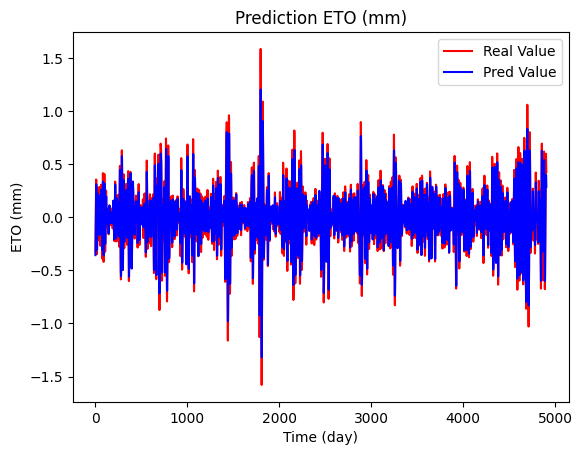

MSE: 0.007225307671459862
MAE: 0.06428120207665756
R²: 0.9082658931523665
RMSE: 0.08500180981284965
pred_finally: [-0.3562136  -0.3242776  -0.22946982 ...  0.37290218  0.3278833
  0.2883543 ]
prediction_result: [-0.3562136  -0.3242776  -0.22946982 ...  0.37290218  0.3278833
  0.2883543 ]
lstm_y_turs: [-0.33046399 -0.26250496 -0.15866618 ...  0.50942294  0.46093815
  0.42654371]
-------------------------- 5 --------------------------
            one       two     three      four      five           six  \
0     -0.826169 -1.337820  0.515877 -0.021205 -1.880795  -1238.158886   
1     -0.901505 -1.384742  0.647517 -0.022810 -1.979773  -1255.023748   
2     -0.934304 -1.401546  0.774530 -0.041143 -2.080201  -1263.141402   
3     -0.909293 -1.391681  0.891331 -0.073654 -2.165465  -1253.146649   
4     -0.825918 -1.374637  0.992247 -0.116823 -2.215935  -1218.249177   
...         ...       ...       ...       ...       ...           ...   
24525  0.123502 -0.367083 -0.808054 -0.015135  1.669

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_17876\2926629309.py:108: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_BiLSTM_Model = KerasRegressor(CNN_BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 6s 11ms/step - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 3.6378e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 3s 10ms/step - loss: 9.2736e-04 - accuracy: 0.0000e+00 - val_loss: 2.8890e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 3s 10ms/step - loss: 7.2173e-04 - accuracy: 0.0000e+00 - val_loss: 6.5295e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 3s 10ms/step - loss: 6.8540e-04 - accuracy: 0.0000e+00 - val_loss: 6.5585e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 3s 10ms/step - loss: 6.5643e-04 - accuracy: 0.0000e+00 - val_loss: 5.9178e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 3s 10ms/step - loss: 5.8881e-04 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 3s 10ms/ste

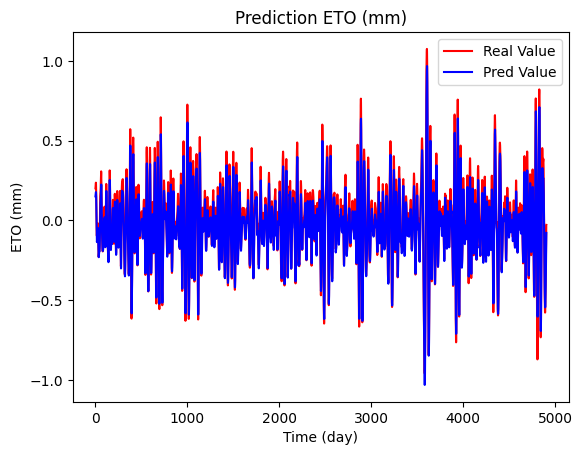

MSE: 0.003962910543692511
MAE: 0.0501050059225828
R²: 0.9371581355154132
RMSE: 0.06295165243019846
pred_finally: [ 0.15076454  0.15620077  0.1612603  ... -0.14693639 -0.10144842
 -0.07818887]
prediction_result: [ 0.15076454  0.15620077  0.1612603  ... -0.14693639 -0.10144842
 -0.07818887]
lstm_y_turs: [ 0.20117115  0.20871215  0.21738666 ... -0.05924301 -0.03032325
 -0.02786112]
-------------------------- 6 --------------------------
            one       two     three      four      five           six  \
0      1.928907  1.199636  0.270012 -0.869554 -1.364838  -1616.392266   
1      1.949215  1.249280  0.288430 -0.873038 -1.372098  -1692.993038   
2      1.959629  1.308219  0.310103 -0.868264 -1.354231  -1744.598684   
3      1.962431  1.375429  0.334793 -0.855393 -1.312153  -1770.009776   
4      1.959622  1.450769  0.360931 -0.834913 -1.248742  -1768.183721   
...         ...       ...       ...       ...       ...           ...   
24525 -0.982413 -0.737453 -0.779654 -0.176705  3.51

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_17876\2926629309.py:108: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_BiLSTM_Model = KerasRegressor(CNN_BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 5s 10ms/step - loss: 0.0076 - accuracy: 1.0193e-04 - val_loss: 3.1865e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 3s 9ms/step - loss: 8.3822e-04 - accuracy: 1.0193e-04 - val_loss: 3.2997e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 3s 9ms/step - loss: 7.6486e-04 - accuracy: 1.0193e-04 - val_loss: 3.2582e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 3s 9ms/step - loss: 6.5691e-04 - accuracy: 1.0193e-04 - val_loss: 2.9388e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 3s 9ms/step - loss: 6.3873e-04 - accuracy: 1.0193e-04 - val_loss: 4.3713e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 3s 9ms/step - loss: 6.1991e-04 - accuracy: 1.0193e-04 - val_loss: 3.6046e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 3s 9ms/step 

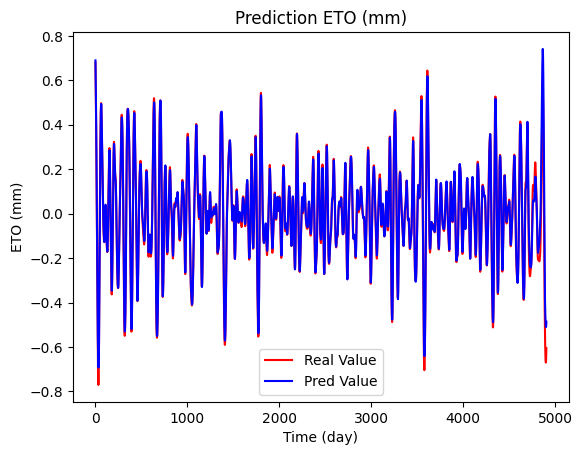

MSE: 0.0009788913755928884
MAE: 0.02065638504165988
R²: 0.978107321328683
RMSE: 0.03128723982061838
pred_finally: [ 0.68950635  0.6623124   0.6307781  ... -0.5053038  -0.4980716
 -0.48665532]
prediction_result: [ 0.68950635  0.6623124   0.6307781  ... -0.5053038  -0.4980716
 -0.48665532]
lstm_y_turs: [ 0.6805114   0.64891006  0.61484291 ... -0.64513045 -0.62748226
 -0.60462463]
-------------------------- 7 --------------------------
            one       two     three      four      five           six  \
0     -3.219874 -5.485443  0.444272  0.209120 -1.074872   -466.674561   
1     -3.227455 -5.520673  0.455919  0.204964 -1.069695   -448.973719   
2     -3.237745 -5.552130  0.464966  0.202024 -1.058711   -429.230702   
3     -3.251243 -5.579408  0.471272  0.200244 -1.041853   -407.346748   
4     -3.268508 -5.602469  0.474697  0.199483 -1.019074   -383.370771   
...         ...       ...       ...       ...       ...           ...   
24525  1.650553  3.775691 -0.054213 -0.171277  1.384

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_17876\2926629309.py:108: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_BiLSTM_Model = KerasRegressor(CNN_BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 6s 10ms/step - loss: 0.0054 - accuracy: 0.0000e+00 - val_loss: 1.8511e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 3s 9ms/step - loss: 5.3743e-04 - accuracy: 0.0000e+00 - val_loss: 4.2805e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 3s 9ms/step - loss: 4.3602e-04 - accuracy: 0.0000e+00 - val_loss: 1.6540e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 3s 9ms/step - loss: 4.2109e-04 - accuracy: 0.0000e+00 - val_loss: 2.2141e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 3s 9ms/step - loss: 3.5779e-04 - accuracy: 0.0000e+00 - val_loss: 1.8522e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 3s 10ms/step - loss: 3.2339e-04 - accuracy: 0.0000e+00 - val_loss: 2.6903e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 3s 9ms/step

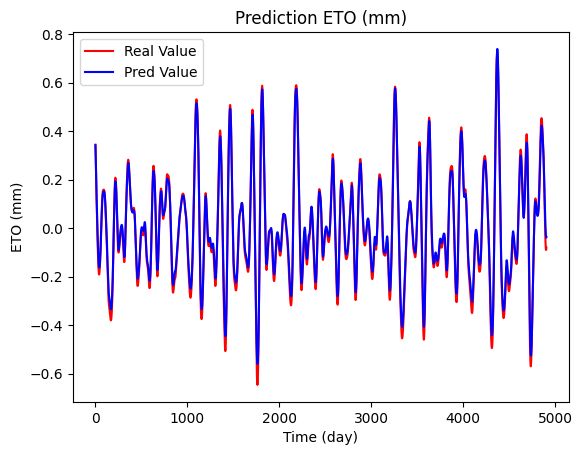

MSE: 0.0005770324483375364
MAE: 0.019749855073636545
R²: 0.9883457669162636
RMSE: 0.024021499710416425
pred_finally: [ 0.34218115  0.32869363  0.3143443  ... -0.03872499 -0.03846166
 -0.03654281]
prediction_result: [ 0.34218115  0.32869363  0.3143443  ... -0.03872499 -0.03846166
 -0.03654281]
lstm_y_turs: [ 0.34474668  0.329054    0.312468   ... -0.08822079 -0.08503254
 -0.08037438]
-------------------------- 8 --------------------------
            one       two     three      four      five           six  \
0      0.795884 -2.062031  0.525401 -0.006315 -0.727792  -1078.049619   
1      0.822904 -2.065012  0.528755 -0.009697 -0.730367  -1086.374612   
2      0.851711 -2.066206  0.532036 -0.013404 -0.731635  -1094.829374   
3      0.882275 -2.065579  0.535246 -0.017434 -0.731553  -1103.436139   
4      0.914519 -2.063140  0.538391 -0.021782 -0.730096  -1112.191238   
...         ...       ...       ...       ...       ...           ...   
24525  3.175849  1.980456  0.699727  0.145954 -

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_17876\2926629309.py:108: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_BiLSTM_Model = KerasRegressor(CNN_BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 5s 9ms/step - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 6.6249e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 2s 8ms/step - loss: 8.0611e-04 - accuracy: 0.0000e+00 - val_loss: 4.9695e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 2s 8ms/step - loss: 5.7774e-04 - accuracy: 0.0000e+00 - val_loss: 9.4065e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 2s 8ms/step - loss: 5.7583e-04 - accuracy: 0.0000e+00 - val_loss: 3.3905e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 2s 8ms/step - loss: 5.2316e-04 - accuracy: 0.0000e+00 - val_loss: 7.2126e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 2s 8ms/step - loss: 4.3814e-04 - accuracy: 0.0000e+00 - val_loss: 7.8815e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 2s 8ms/step -

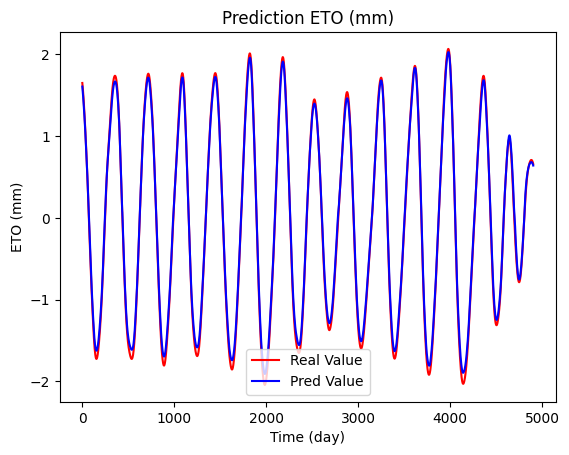

MSE: 0.003695687026658115
MAE: 0.05239466314982371
R²: 0.997435694111195
RMSE: 0.060792162543029465
pred_finally: [1.6069592  1.5946028  1.5820041  ... 0.64834017 0.64456266 0.64059937]
prediction_result: [1.6069592  1.5946028  1.5820041  ... 0.64834017 0.64456266 0.64059937]
lstm_y_turs: [1.65113333 1.64004312 1.62842536 ... 0.66911005 0.66466237 0.65999992]
-------------------------- 9 --------------------------
            one       two     three      four      five           six  \
0     -3.395099 -2.809848 -0.004397  0.231498 -1.222674      4.595343   
1     -3.408695 -2.811715 -0.004194  0.232764 -1.225061      6.431001   
2     -3.422006 -2.813528 -0.003995  0.233998 -1.227102      8.606319   
3     -3.435029 -2.815286 -0.003800  0.235202 -1.228801     11.115898   
4     -3.447763 -2.816988 -0.003610  0.236372 -1.230158     13.950662   
...         ...       ...       ...       ...       ...           ...   
24525  2.425023  1.918073  1.100583  0.069358  1.751016  20640.874202  

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_17876\2926629309.py:108: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_BiLSTM_Model = KerasRegressor(CNN_BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


Epoch 1/20
307/307 [==============================] - 5s 11ms/step - loss: 0.0065 - accuracy: 0.0000e+00 - val_loss: 9.0283e-04 - val_accuracy: 2.0387e-04
Epoch 2/20
307/307 [==============================] - 3s 10ms/step - loss: 6.4396e-04 - accuracy: 0.0000e+00 - val_loss: 9.1455e-04 - val_accuracy: 2.0387e-04
Epoch 3/20
307/307 [==============================] - 3s 10ms/step - loss: 4.7149e-04 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 2.0387e-04
Epoch 4/20
307/307 [==============================] - 3s 10ms/step - loss: 3.9261e-04 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 2.0387e-04
Epoch 5/20
307/307 [==============================] - 3s 10ms/step - loss: 3.7639e-04 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 2.0387e-04
Epoch 6/20
307/307 [==============================] - 3s 10ms/step - loss: 3.4066e-04 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 2.0387e-04
Epoch 7/20
307/307 [==============================] - 3s 10ms/step

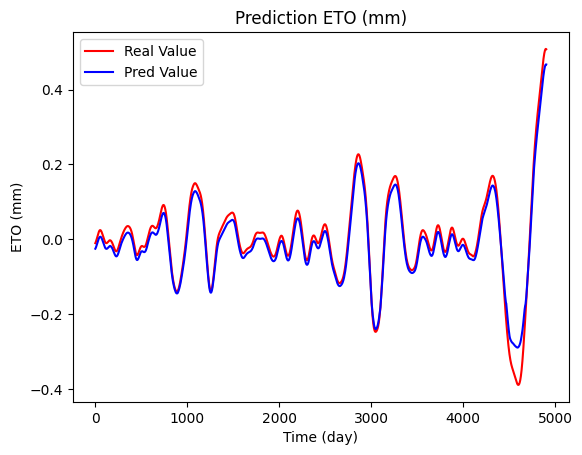

MSE: 0.0005365306194389927
MAE: 0.018569830265219762
R²: 0.9653256187292883
RMSE: 0.023163130605317425
pred_finally: [-0.02513082 -0.02470114 -0.02424691 ...  0.4675543   0.4675074
  0.46738088]
prediction_result: [-0.02513082 -0.02470114 -0.02424691 ...  0.4675543   0.4675074
  0.46738088]
lstm_y_turs: [-0.01020272 -0.00967183 -0.00910924 ...  0.50870622  0.50846859
  0.50814429]
-------------------------- 10 --------------------------
            one       two     three      four      five           six  \
0     -0.469599 -0.280273 -0.842040 -0.310257  5.121896   -854.141494   
1     -0.470964 -0.279857 -0.844430 -0.310420  5.133671   -853.328051   
2     -0.472273 -0.279384 -0.846795 -0.310560  5.145205   -852.474965   
3     -0.473527 -0.278853 -0.849136 -0.310678  5.156497   -851.581444   
4     -0.474724 -0.278265 -0.851452 -0.310774  5.167548   -850.646626   
...         ...       ...       ...       ...       ...           ...   
24525  0.862693  1.341498 -0.163741  0.045221  0

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_17876\2926629309.py:108: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_BiLSTM_Model = KerasRegressor(CNN_BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


307/307 [==============================] - 5s 10ms/step - loss: 0.0076 - accuracy: 0.0000e+00 - val_loss: 1.6206e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 3s 9ms/step - loss: 6.3942e-04 - accuracy: 0.0000e+00 - val_loss: 3.5806e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 3s 9ms/step - loss: 5.4639e-04 - accuracy: 0.0000e+00 - val_loss: 4.7960e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 3s 9ms/step - loss: 5.1809e-04 - accuracy: 0.0000e+00 - val_loss: 6.5121e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 3s 9ms/step - loss: 4.1338e-04 - accuracy: 0.0000e+00 - val_loss: 6.9195e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 3s 9ms/step - loss: 4.1500e-04 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================] - 3s 9ms/step - lo

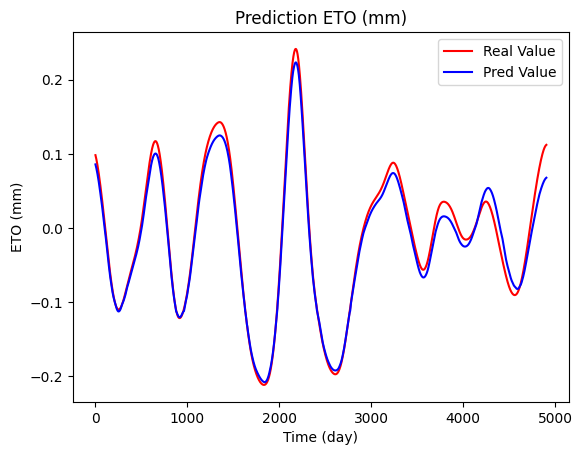

MSE: 0.00017398771826524815
MAE: 0.010414434110922525
R²: 0.9819714471428573
RMSE: 0.013190440412103311
pred_finally: [0.08590464 0.0854305  0.08494325 ... 0.06770037 0.06780116 0.06789513]
prediction_result: [0.08590464 0.0854305  0.08494325 ... 0.06770037 0.06780116 0.06789513]
lstm_y_turs: [0.09834981 0.09785964 0.09735627 ... 0.11204367 0.1121496  0.11224567]
-------------------------- 11 --------------------------
            one       two     three      four      five           six  \
0     -0.770274 -0.335700 -0.511797 -0.136474  1.225237   -525.053920   
1     -0.770275 -0.336619 -0.512329 -0.136544  1.225578   -524.760084   
2     -0.770269 -0.337541 -0.512849 -0.136612  1.225903   -524.449984   
3     -0.770253 -0.338465 -0.513358 -0.136678  1.226211   -524.123608   
4     -0.770229 -0.339391 -0.513856 -0.136742  1.226503   -523.780949   
...         ...       ...       ...       ...       ...           ...   
24525  0.947129  0.354504 -0.382501  0.062982  0.009957  11494.389

C:\Users\AnleHrc\AppData\Local\Temp\ipykernel_17876\2926629309.py:108: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  CNN_BiLSTM_Model = KerasRegressor(CNN_BiLSTM, epochs=40, verbose=1, validation_data=(testX, testY))


Epoch 1/20
307/307 [==============================] - 6s 11ms/step - loss: 0.0078 - accuracy: 0.0000e+00 - val_loss: 1.7718e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
307/307 [==============================] - 3s 11ms/step - loss: 7.2333e-04 - accuracy: 0.0000e+00 - val_loss: 1.7886e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
307/307 [==============================] - 3s 11ms/step - loss: 5.4124e-04 - accuracy: 0.0000e+00 - val_loss: 5.3784e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
307/307 [==============================] - 3s 11ms/step - loss: 4.8168e-04 - accuracy: 0.0000e+00 - val_loss: 8.3649e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
307/307 [==============================] - 3s 11ms/step - loss: 4.4000e-04 - accuracy: 0.0000e+00 - val_loss: 9.5156e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
307/307 [==============================] - 3s 11ms/step - loss: 4.1167e-04 - accuracy: 0.0000e+00 - val_loss: 9.1136e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
307/307 [==============================

In [14]:
%%time
if __name__ == '__main__':
    days = ['OneDay','ThreeDay','FiveDay','FifteenDay']
    for day in days:
       print('------------------',day ,'--------------------')
       print('This is ',day,'-th for prediction et0')
       reshape1,finally_y_true,finally_rsult,day = ceemdan_lstm(day)
       print('This is ',day,'-th for prediction et0')
       print('------------------',day,'---------------------')
       plot_save_true_prediction(reshape1,finally_y_true,finally_rsult,day)